In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid", palette="viridis")

df = pd.read_csv("cleaned_dataset_EDA.csv")

df = df.drop(columns=[col for col in df.columns if col.startswith("Unnamed")],
             errors="ignore")

df["popularity"] = pd.to_numeric(df["popularity"], errors="coerce")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns for analysis: {numeric_cols}")

desc_stats = df.describe().transpose()
print("Summary Statistics:")
print(desc_stats[["mean", "std", "min", "50%", "max"]])


Numerical columns for analysis: ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
Summary Statistics:
                           mean            std       min            50%  \
popularity            34.720996      19.526807     0.000      35.000000   
duration_ms       231276.522727  115830.598763  8586.000  215239.000000   
danceability           0.559441       0.177296     0.000       0.573000   
energy                 0.634864       0.258436     0.000       0.678000   
key                    5.284096       3.557798     0.000       5.000000   
loudness              -8.587417       5.284652   -49.531      -7.264500   
mode                   0.633808       0.481766     0.000       1.000000   
speechiness            0.088521       0.115810     0.000       0.049000   
acousticness           0.329985       0.339976     0.000       0.191000   
instrumentalne

Before looking at specific relationships, we first checked the basic distribution of all numeric variables. Most tracks have a popularity score around the mid-30s out of 100, which means the dataset is dominated by “regular” songs rather than global hits. Track durations mostly sit around typical song length (about 3-4 minutes), but there are a few extreme outliers that are much longer. Features like danceability, energy, acousticness, and instrumentalness are all bounded between 0 and 1 and show clear skew, which is expected for audio feature scores. Overall this confirms that the dataset looks reasonable but contains some extreme values that could influence later modeling if not handled carefully.

In the statistical learning framework, popularity is our response Y and the audio features form X. The goal of this EDA is to understand the structure of f(X) before building prediction models. Although key and mode appear as numeric variables (0–11 for key, 0/1 for mode), they are categorical in nature. Their low correlation with popularity is expected because their numeric values do not reflect a meaningful quantitative scale.

Correlations with Popularity:
 popularity          1.000000
loudness            0.092522
danceability        0.087962
time_signature      0.040292
valence             0.013237
key                 0.004472
energy              0.002881
tempo               0.001757
mode               -0.003895
liveness           -0.029868
acousticness       -0.037057
duration_ms        -0.051300
speechiness        -0.064908
instrumentalness   -0.174544
Name: popularity, dtype: float64


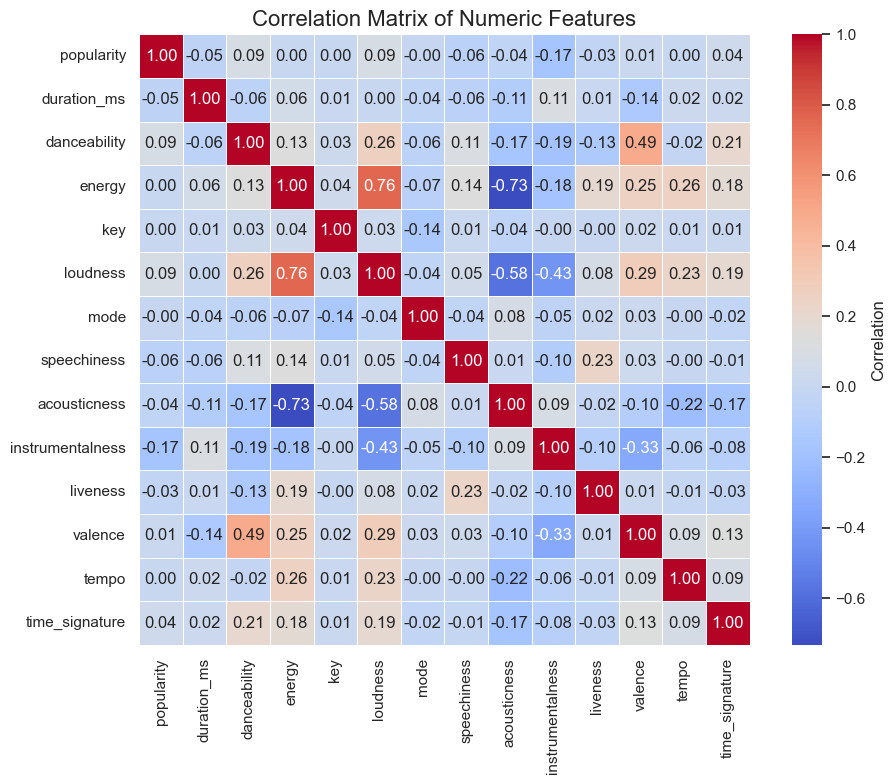

In [30]:
corr_matrix = df[numeric_cols].corr()

pop_corr = corr_matrix["popularity"].sort_values(ascending=False)
print("Correlations with Popularity:\n", pop_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()


Linear relationships between popularity and audio features
The correlation matrix shows that popularity has only weak linear relationships with the individual audio features. Instrumentalness has the strongest (negative) correlation with popularity (≈ –0.17), meaning heavily instrumental tracks tend to be less popular on average. Loudness and danceability have small positive correlations (around 0.09), suggesting that louder and more danceable songs are slightly more popular but the effect is modest. All other features have near-zero correlations with popularity. This tells us two important things for the rest of the project: there is no single “magic” feature that predicts popularity on its own, and any useful model will likely need to combine several features and possibly nonlinear effects rather than relying on simple one-to-one relationships.

The correlations with Y are very small, which indicates a low-signal prediction problem. This means linear models will struggle to achieve high R² without adding interactions or more flexible functions. Time_signature is also an ordinal/categorical variable with only a few possible values (typically 3, 4, or 5), so its low linear correlation with popularity is unsurprising and does not necessarily imply irrelevance.

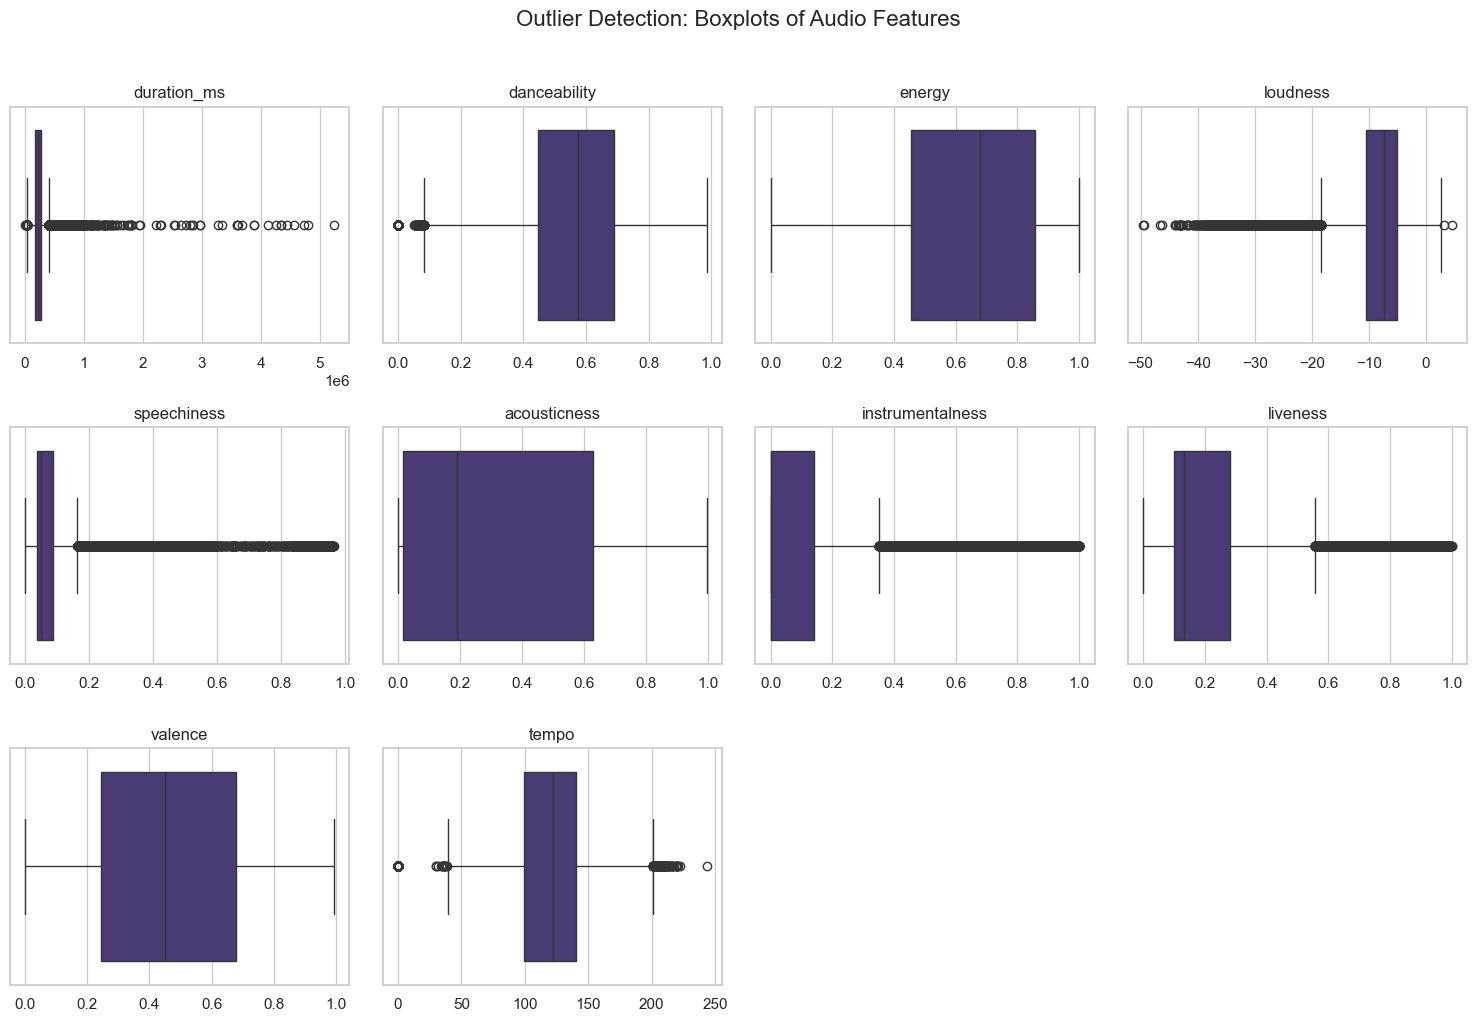

In [31]:
features_to_check = [
    "duration_ms", "danceability", "energy", "loudness",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo",
]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, features_to_check):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")

for ax in axes[len(features_to_check):]:
    ax.set_visible(False)

fig.suptitle("Outlier Detection: Boxplots of Audio Features", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()


To understand how each feature behaves individually, we plotted boxplots for all the main audio variables. Duration stands out as heavily right-skewed, with a long tail of very long tracks that will behave like outliers. Many of the 0–1 features (such as acousticness, instrumentalness, and speechiness) show most values clustered near 0 with a smaller number of tracks taking larger values. Loudness spans a fairly wide range but most songs fall into a relatively narrow band. The plots confirm that the dataset contains genuine variability in musical characteristics, along with several extreme values that we should keep in mind when fitting models.

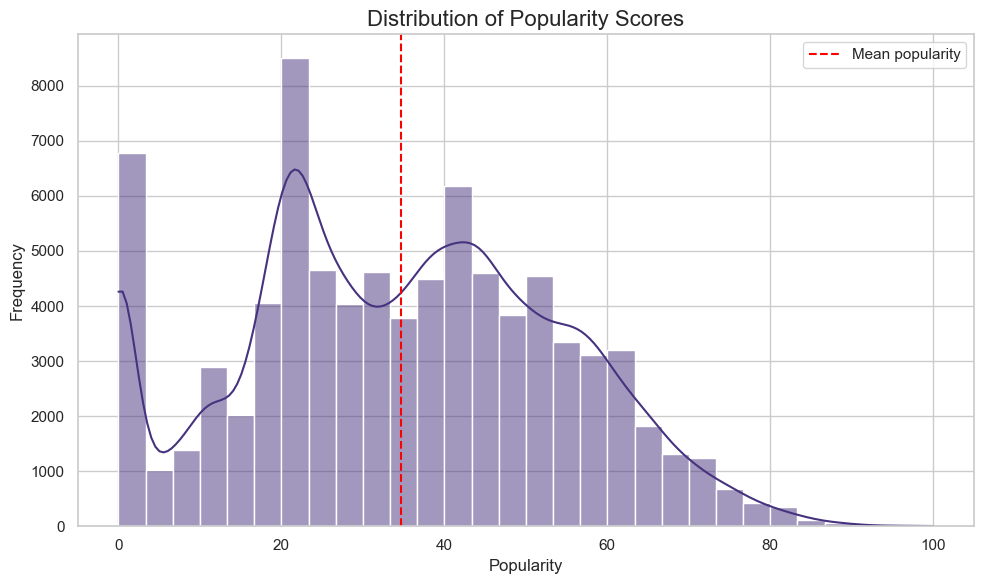

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df["popularity"], kde=True, bins=30)
plt.title("Distribution of Popularity Scores", fontsize=16)
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.axvline(x=df["popularity"].mean(),
            color="red", linestyle="--", label="Mean popularity")
plt.legend()
plt.tight_layout()
plt.show()

bins = [0, 20, 40, 60, 80, 101]
labels = ["0–20", "20–40", "40–60", "60–80", "80–100"]
df["popularity_tier"] = pd.cut(
    df["popularity"],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True,
)


The popularity scores are far from uniform. Most songs fall between 0 and 60, with a large mass around the 20–40 range, and only a small fraction reach very high popularity scores close to 100. The mean is around 35, which reinforces that this dataset contains many ordinary tracks and relatively few “viral” songs. From a modeling perspective, this means predicting the very top-end hits is likely to be harder than modeling the bulk of the mid-range songs, because we have fewer examples in that extreme region.

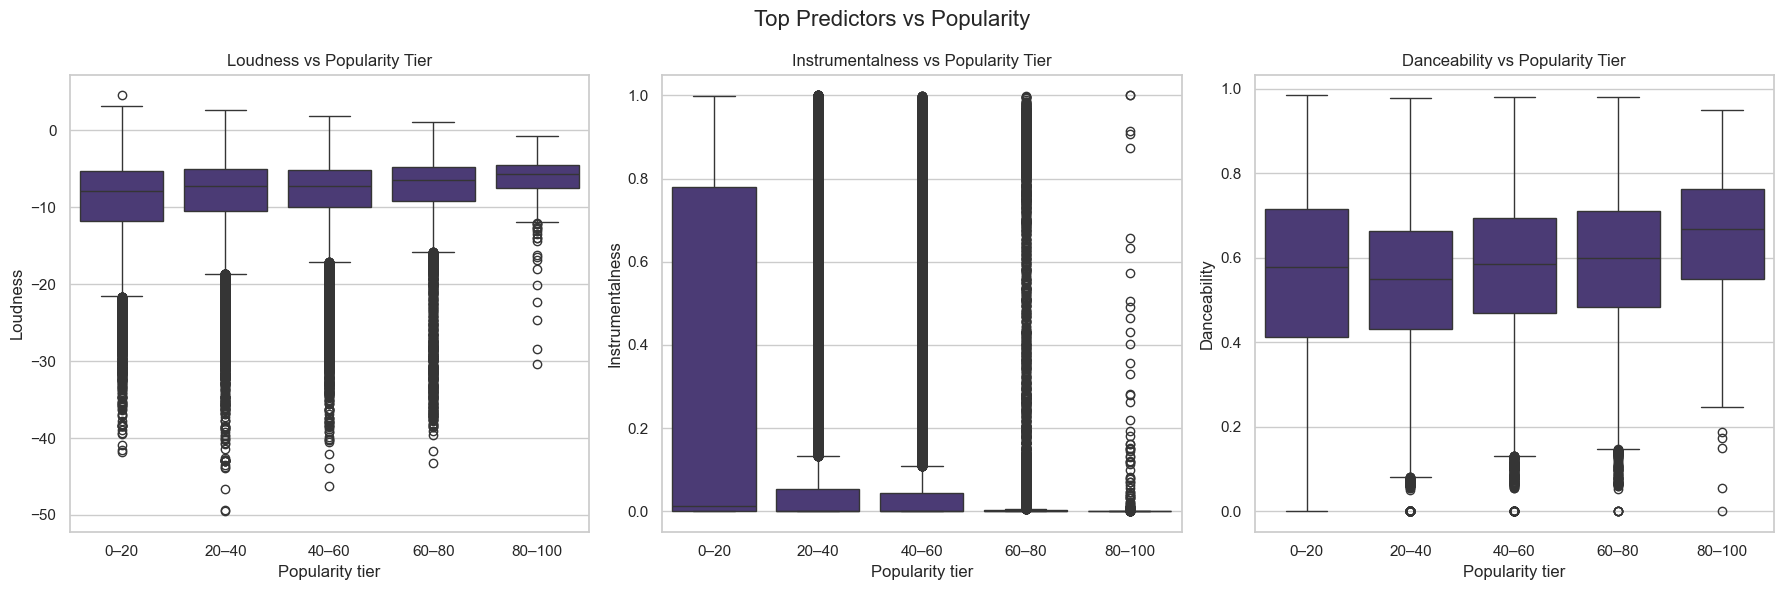

In [33]:
real_top_features = ["loudness", "instrumentalness", "danceability"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

for ax, feature in zip(axes, real_top_features):
    sns.boxplot(
        data=df,
        x="popularity_tier",
        y=feature,
        ax=ax,
    )
    ax.set_title(f"{feature.title()} vs Popularity Tier")
    ax.set_xlabel("Popularity tier")
    ax.set_ylabel(feature.title())

fig.suptitle("Top Predictors vs Popularity", fontsize=16)
fig.tight_layout()
plt.show()


To make the patterns easier to interpret, we grouped songs into popularity tiers and looked at how the main predictors behave across those groups. Loudness shows a mild upward trend: more popular songs tend to be a bit louder on average, and the lowest-popularity tier contains more very quiet tracks. Instrumentalness goes the opposite way: as we move into higher popularity tiers, instrumentalness drops, which supports the idea that highly instrumental tracks are less likely to become mainstream hits. Danceability shows the clearest positive pattern higher popularity tiers tend to have higher danceability scores and fewer tracks that are very hard to dance to. Together, these plots suggest that popular songs tend to be relatively loud, danceable, and not heavily instrumental.

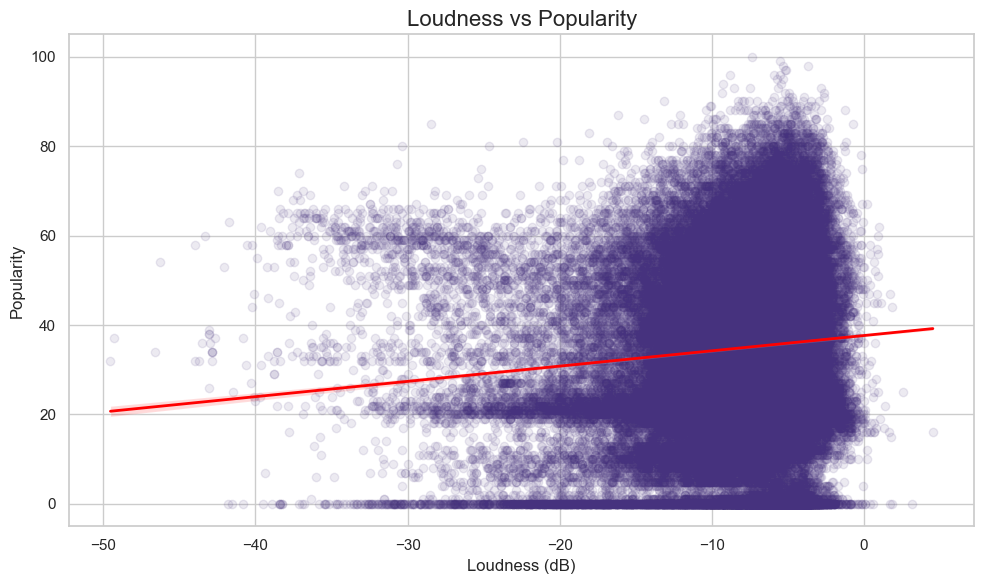

In [34]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="loudness",
    y="popularity",
    scatter_kws={"alpha": 0.1},
    line_kws={"color": "red", "linewidth": 2},
)
plt.title("Loudness vs Popularity", fontsize=16)
plt.xlabel("Loudness (dB)")
plt.ylabel("Popularity")
plt.tight_layout()
plt.show()


Looking at the raw scatter plot of loudness vs popularity, there is no strong, clean line, but there is a weak pattern. Extremely quiet tracks almost never reach very high popularity, whereas songs in a more typical loudness range have a chance to be either unpopular or very popular. In other words loudness alone is not enough to predict how popular a song will be, but very low loudness appears to be a slight disadvantage. This reinforces the idea from the correlation analysis: loudness has a small positive association with popularity, but the relationship is noisy and needs to be considered together with other features.

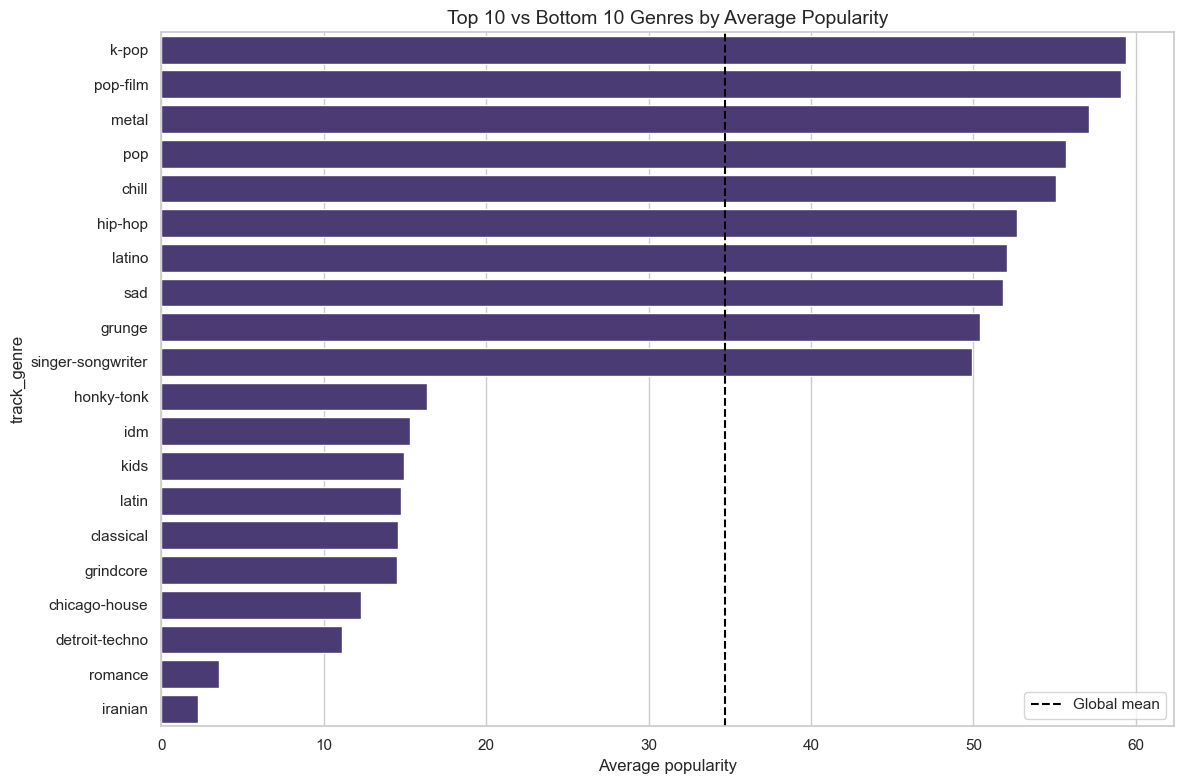

In [35]:
genre_pop = (
    df.groupby("track_genre")["popularity"]
      .mean()
      .sort_values(ascending=False)
)

top_10_genres = genre_pop.head(10)
bottom_10_genres = genre_pop.tail(10)

contrast_genres = pd.concat([top_10_genres, bottom_10_genres])

plt.figure(figsize=(12, 8))
sns.barplot(
    x=contrast_genres.values,
    y=contrast_genres.index,
)
plt.title("Top 10 vs Bottom 10 Genres by Average Popularity", fontsize=14)
plt.xlabel("Average popularity")
plt.axvline(
    x=df["popularity"].mean(),
    color="black",
    linestyle="--",
    label="Global mean",
)
plt.legend()
plt.tight_layout()
plt.show()


When we aggregate by genre, it becomes clear that some genres start with a built-in popularity advantage. Genres like k-pop, pop, and other mainstream styles have average popularity scores significantly above the global mean, while more niche or traditional genres (such as classical or opera) sit well below it. This suggests that genre acts like a macro-level predictor: even before looking at detailed audio features, certain genres are more likely to produce higher-popularity tracks. For modeling, this means genre should either be included explicitly or we need to be aware that different genres may have different baseline levels and potentially different relationships between the features and popularity.

Genre appears to shift the baseline of Y, suggesting that the conditional expectation E[Y | genre] differs substantially across genres. This aligns with the idea that groups can have different underlying functions, meaning the relationship between predictors and the response is heterogeneous across categories.

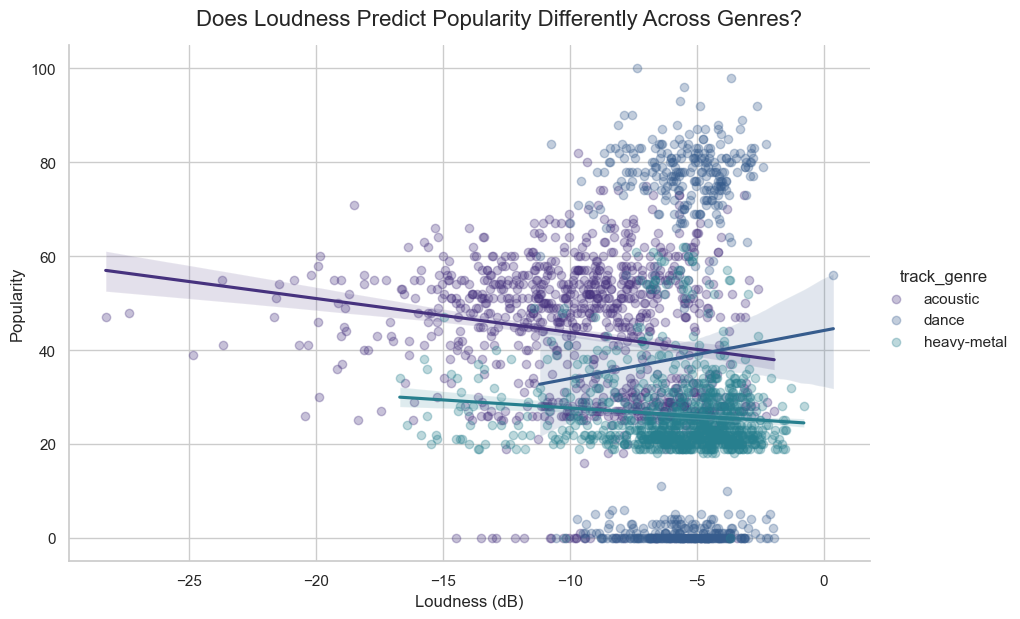

In [36]:
target_genres = ["acoustic", "heavy-metal", "dance"]
subset = df[df["track_genre"].isin(target_genres)].copy()

g = sns.lmplot(
    data=subset,
    x="loudness",
    y="popularity",
    hue="track_genre",
    height=6,
    aspect=1.5,
    scatter_kws={"alpha": 0.3},
)

g.set_axis_labels("Loudness (dB)", "Popularity")
g.fig.suptitle(
    "Does Loudness Predict Popularity Differently Across Genres?",
    fontsize=16,
    y=1.03,
)
plt.show()



To check for possible interactions we looked at the relationship between loudness and popularity separately for three very different genres: acoustic, heavy metal, and dance. The scatterplot with fitted lines shows two key patterns. First, the baseline popularity level is very different across genres dance tracks tend to reach higher popularity overall, while acoustic songs cluster at lower scores. Second, the slope of loudness is not the same for every genre. In dance music, louder tracks are more likely to be popular, whereas in acoustic music changes in loudness have a much weaker effect on popularity. This suggests that the impact of audio features like loudness is genre-dependent, and a single global linear model may not fully capture the true structure without allowing for such interactions.

The difference in slopes across genres reflects an interaction effect: the influence of loudness on popularity depends on genre. This matches the idea that linear models without interaction terms may fail when f(X) varies across groups.